# CSDS 440: P2 - Logistic Regression and Naive Bayes

Daniel Shao and Ryan Tatton

16 October 2020

For training the models, Google Colab was utilized because of its ability to run multiple GPU-powered notebooks simultaneously. For this reason, the line of code, `with tf.device('/device:GPU:0')`, was commented out in this notebook since it only applies to running in Google Colab.

# Setup

In [176]:
import nbayes, logreg, mldata, mainutil
import collections
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import distutils

In [194]:
def format_results_dict(results, keys):
    return {
        key : {
            dataset : {
                metric: round(value, 4) for metric, value in results[key][dataset].items()
        } for dataset in datasets
    } for key in keys
}

In [411]:
datasets = ['voting', 'volcanoes', 'spam']
nb = nbayes.NaiveBayes(laplace_m=0.1)
lr = logreg.LogisticRegression(cost=0.1)
learners = {
    nb.get_name(): nb, 
    lr.get_name(): lr
}

# Part A

For training, 5-fold stratified cross validation was used for all datasets. Note continuous variables were discretized into 2 bins for naive Bayes. Additionally, for logistic regression, 1000 iterations were executed and the step size was set to 0.5.

## Train

In [ ]:
part_a = collections.defaultdict(dict)
for dataset in datasets:
    for name, learner in learners.items():
        # with tf.device('/device:GPU:0'):
        results = mainutil.p2_main(
            path=f'..\\{dataset}', 
            learner=learner, 
            skip_cv=False, 
            print_results=False,
            save_as=f'{learner.get_name()}_{dataset}'
          )
        part_a[name][dataset] = results
with open('part_a_results.txt', 'w') as f:
    json.dump(part_a, f)

## Analysis

In [282]:
with open('part_a_results.txt') as f:
    part_a = json.load(f)
    part_a = format_results_dict(part_a, learners)
metrics = list(part_a[nb.get_name()][datasets[0]].keys())
rows = [
    [part_a[learner][dataset][metric] for learner in learners for dataset in datasets]
    for metric in metrics
]
cols = pd.MultiIndex.from_product([list(part_a.keys()), datasets])
part_a_data = pd.DataFrame(data=rows, columns=cols)
part_a_data.index = metrics
part_a_data = part_a_data.transpose()
part_a_data

mean_accuracy  mean_precision  mean_recall  \
NaiveBayes         voting            0.9501          0.9787       0.9083   
                   volcanoes         0.6172          0.4529       0.8099   
                   spam              0.6847          0.7223       0.8055   
LogisticRegression voting            0.8980          0.8816       0.9077   
                   volcanoes         0.7763          0.6136       0.5086   
                   spam              0.6576          0.6670       0.9284   

                              sd_accuracy  sd_precision  sd_recall     auc  \
NaiveBayes         voting          0.0219        0.0344     0.0217  0.9869   
                   volcanoes       0.0174        0.0152     0.0371  0.5550   
                   spam            0.0049        0.0028     0.0065  0.7240   
LogisticRegression voting          0.0416        0.0881     0.0644  0.9458   
                   volcanoes       0.0611        0.3616     0.3125  0.7399   
                   spam            0.0382        0.0490     0.0757  0.6712   

                              best_threshold  
NaiveBayes         voting             1.0000  
                   volcanoes          1.0000  
                   spam               0.9995  
LogisticRegression voting             0.9970  
                   volcanoes          1.0000  
                   spam               0.9680

# Part B

## Train

In [ ]:
costs = [0, 0.01, 0.1, 1]
part_b = collections.defaultdict(dict)
for dataset in datasets:
    for cost in costs:
        learner = logreg.LogisticRegression(cost=cost)
        # with tf.device('/device:GPU:0'):
        results = mainutil.p2_main(
            path=f'..\\{dataset}',
            learner=learner,
            skip_cv=False,
            print_results=True,
            save_as=f'{learner.get_name()}_{cost}_{dataset}'
        )
        part_b[cost][dataset] = results
with open('part_b_results.txt', 'w') as f:
    json.dump(part_b, f)

## Analysis

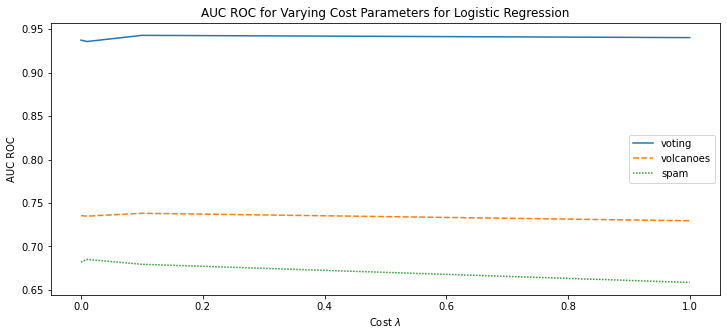

In [413]:
with open('part_b_results.txt') as f:
    part_b = json.load(f)
    part_b = format_results_dict(part_b, [f'{c}' for c in costs])
    part_b = {float(k): v for k, v in part_b.items()}
aucs = {
    dataset: [part_b[cost][dataset]['auc'] 
              for cost in part_b] for dataset in datasets
}
part_b_data = pd.DataFrame([auc for auc in aucs.values()], columns=costs, index=datasets).transpose()
sns.lineplot(data=part_b_data)
plt.xlabel('Cost $\lambda$')
plt.ylabel('AUC ROC')
plt.title('AUC ROC for Varying Cost Parameters for Logistic Regression')
plt.rcParams['figure.figsize'] = (12, 5)

It is evident that as $\lambda$ increased from 0 to 1, the AUC of the ROC decreased nearly monotonically from the spam dataset. It decreased by about 0.01 for the volcanoes dataset and remained about the same for the voting dataset. For reference, here is the tabulated values:

In [418]:
part_b_data

,voting,volcanoes,spam
0.00,0.9374,0.7354,0.6820
0.01,0.9358,0.7348,0.6850
0.10,0.9429,0.7381,0.6794
1.00,0.9403,0.7295,0.6585


# Part C

For the experimental portion of this assignment, the NaiveLogisticRegression learner was trained across all datasets, for margin values of 0, 0.01, 0.1, and 1. See the experiment.py docstrings for details regarding the intuition behind this learner. For comparison, the same learners used in part A were also re-trained here.

Under the circumstance of having more time, an additional experiment would have been performed that removed "near-zero variance" predictors prior to training both naive Bayes and logistic regression. According to *Applied Predictive Modeling* (Kuhn and Johnson, 2016), this can be a beneficial to the performance of both types of models. The function to preform this pre-processing step can be found in the `preprocess.py` module as `remove_near_zero_variance()`.

## Train

In [ ]:
nlr = experiment.NaiveLogisticRegression(
    naive_bayes=nb, log_reg=lr, re_train=True, margin=0.1, use_rank=True
    )
margins = [0, 0.01, 0.1, 1]
part_c = collections.defaultdict(dict)
for dataset in datasets:
    for use_rank in (True, False):
        for margin in margins:
          # with tf.device('/device:GPU:0'):
            results = mainutil.p2_main(
                path=f'..\\{dataset}', 
                learner=nlr,
                skip_cv=False, 
                print_results=True,
                is_experiment=True
            )
            part_c[f'{dataset}_{use_rank}_{margin}'] = results
with open('part_c_results.txt', 'w') as f:
    json.dump(part_c, f)

## Analysis

In [426]:
def parse_part_c_key(key: str):
    dataset, use_rank, margin = key.split('_')
    use_rank = bool(distutils.util.strtobool(use_rank))
    margin = float(margin)
    return dataset, use_rank, margin

In [448]:
with open('part_c_results.txt') as f:
    part_c = json.load(f)
part_c = {
    parse_part_c_key(k): {
        metric: round(value, 4) for metric, value in metrics.items()
    } for k, metrics in part_c.items()
}
cols = pd.MultiIndex.from_tuples(list(part_c.keys()))
rows = [[value for metric, value in metrics.items()] for k, metrics in part_c.items()]
part_c_data = pd.DataFrame(rows, index=cols)
part_c_data.columns = metrics
part_c_data = part_c_data.drop(labels=['auc', 'best_threshold'], axis=1)
part_a_compare= part_a_data.drop(labels=['auc', 'best_threshold'], axis=1)

Given the size of the entire table for part c, it was split by dataset. The results from part A are also displayed for comparison. Note that `True` indicates the rank-based approach was used; otherwise, the deferral to naive Bayes was used.

For the voting dataset, mean recall is notably higher than either naive Bayes or logistic regression when using the rank-based approach. However, when considering accuracy, recall, and precision, in general, the results are mixed regarding if the naive logistic regression outperforms either model.

In [465]:
part_c_data.loc['voting']

mean_accuracy  mean_precision  mean_recall  sd_accuracy  \
True  0.00         0.9387          0.9257       0.9391       0.0187   
      0.01         0.8955          0.8758       0.9286       0.0817   
      0.10         0.9250          0.8900       0.9544       0.0477   
      1.00         0.9387          0.9366       0.9283       0.0284   
False 0.00         0.9410          0.9359       0.9336       0.0259   
      0.01         0.9249          0.9098       0.9232       0.0287   
      0.10         0.9161          0.9014       0.9182       0.0384   
      1.00         0.9296          0.9309       0.9136       0.0186   

            sd_precision  sd_recall  
True  0.00        0.0253     0.0522  
      0.01        0.1327     0.0458  
      0.10        0.0713     0.0371  
      1.00        0.0545     0.0460  
False 0.00        0.0507     0.0232  
      0.01        0.0320     0.0481  
      0.10        0.0696     0.0461  
      1.00        0.0538     0.0372

In [461]:
part_a_compare

mean_accuracy  mean_precision  mean_recall  \
NaiveBayes         voting            0.9501          0.9787       0.9083   
                   volcanoes         0.6172          0.4529       0.8099   
                   spam              0.6847          0.7223       0.8055   
LogisticRegression voting            0.8980          0.8816       0.9077   
                   volcanoes         0.7763          0.6136       0.5086   
                   spam              0.6576          0.6670       0.9284   

                              sd_accuracy  sd_precision  sd_recall  
NaiveBayes         voting          0.0219        0.0344     0.0217  
                   volcanoes       0.0174        0.0152     0.0371  
                   spam            0.0049        0.0028     0.0065  
LogisticRegression voting          0.0416        0.0881     0.0644  
                   volcanoes       0.0611        0.3616     0.3125  
                   spam            0.0382        0.0490     0.0757

In [406]:
part_c_data.loc['volcanoes']

mean_accuracy  mean_precision  mean_recall  sd_accuracy  \
True  0.00         0.7804          0.7409       0.4581       0.0616   
      0.01         0.7821          0.5996       0.5361       0.0636   
      0.10         0.7768          0.7269       0.5821       0.0556   
      1.00         0.7719          0.5749       0.5192       0.0579   
False 0.00         0.7701          0.8176       0.4205       0.0551   
      0.01         0.7804          0.6980       0.4007       0.0619   
      0.10         0.7790          0.6859       0.5155       0.0623   
      1.00         0.7768          0.7444       0.5293       0.0633   

            sd_precision  sd_recall  
True  0.00        0.1589     0.2679  
      0.01        0.3474     0.3153  
      0.10        0.0951     0.3023  
      1.00        0.3262     0.3007  
False 0.00        0.1594     0.2963  
      0.01        0.3985     0.2399  
      0.10        0.1073     0.2934  
      1.00        0.0996     0.2982

In [462]:
part_a_compare

mean_accuracy  mean_precision  mean_recall  \
NaiveBayes         voting            0.9501          0.9787       0.9083   
                   volcanoes         0.6172          0.4529       0.8099   
                   spam              0.6847          0.7223       0.8055   
LogisticRegression voting            0.8980          0.8816       0.9077   
                   volcanoes         0.7763          0.6136       0.5086   
                   spam              0.6576          0.6670       0.9284   

                              sd_accuracy  sd_precision  sd_recall  
NaiveBayes         voting          0.0219        0.0344     0.0217  
                   volcanoes       0.0174        0.0152     0.0371  
                   spam            0.0049        0.0028     0.0065  
LogisticRegression voting          0.0416        0.0881     0.0644  
                   volcanoes       0.0611        0.3616     0.3125  
                   spam            0.0382        0.0490     0.0757

In [464]:
part_c_data.loc['spam']

mean_accuracy  mean_precision  mean_recall  sd_accuracy  \
True  0.00         0.6378          0.6969       0.7484       0.0511   
      0.01         0.6386          0.7178       0.6965       0.0329   
      0.10         0.6394          0.7163       0.7034       0.0415   
      1.00         0.6272          0.7236       0.6582       0.0278   
False 0.00         0.6462          0.7227       0.7024       0.0497   
      0.01         0.6529          0.7178       0.7329       0.0418   
      0.10         0.6679          0.7278       0.7492       0.0100   
      1.00         0.6457          0.7185       0.7263       0.0281   

            sd_precision  sd_recall  
True  0.00        0.0441     0.0374  
      0.01        0.0242     0.0640  
      0.10        0.0331     0.0774  
      1.00        0.0293     0.0813  
False 0.00        0.0108     0.1121  
      0.01        0.0228     0.0807  
      0.10        0.0034     0.0222  
      1.00        0.0436     0.0960

In [463]:
part_a_compare

mean_accuracy  mean_precision  mean_recall  \
NaiveBayes         voting            0.9501          0.9787       0.9083   
                   volcanoes         0.6172          0.4529       0.8099   
                   spam              0.6847          0.7223       0.8055   
LogisticRegression voting            0.8980          0.8816       0.9077   
                   volcanoes         0.7763          0.6136       0.5086   
                   spam              0.6576          0.6670       0.9284   

                              sd_accuracy  sd_precision  sd_recall  
NaiveBayes         voting          0.0219        0.0344     0.0217  
                   volcanoes       0.0174        0.0152     0.0371  
                   spam            0.0049        0.0028     0.0065  
LogisticRegression voting          0.0416        0.0881     0.0644  
                   volcanoes       0.0611        0.3616     0.3125  
                   spam            0.0382        0.0490     0.0757